In [6]:
using Yao
using FLOYao
using Statistics

N = 2

g = chain(N)
push!(g, rot(kron(N, 1 => X, 2 => X), 0.)) #Rxx on two qubits
dispatch!(g, rand(nparameters(g)).*2π)
theta = first(parameters(g))
println("true gradient: ", sin(theta)/2)

function loss(theta = theta)
    sin(theta/2)^2
end

ratio = 0
function pprior() #For each square, probability ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

function postprocess(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

samplemean_batch = 5000
function run_g(nbatch = samplemean_batch)
    samples = []
    for i in 1:nbatch
        z = pprior() #MajoranaReg object
        result = z |> g |> measure |> postprocess
        if i == 1
            samples = result
        else
            samples = hcat(samples, result) #is this operation slow; on another note there has to be a better way to write this function right
        end
    end
    samples
end
#outputs an N * #samples matrix

function run_d_fake(samples)
    # if size(samples)[1] != N || typeof(samples) != Matrix{Int64} #Require samples to be an N x #samples matrix
    #     println("Improper formatting of samples")
    #     return
    # end
    # samples |> d
    mean(samples, dims = 1)
end

function gLoss(nbatch = samplemean_batch)
    #-mean(log.(run_d_fake(run_g(nbatch))))
    mean(run_d_fake(run_g(nbatch)))
end

eps = 1e-5
function finitediff_grad(g = g, eps = eps) #Computes forward finite differences
    original = gLoss()
    println("original loss: $original")
    a = loss(theta)
    println("original true loss: $a")
    temp_params = parameters(g)
    grad = zeros(nparameters(g))
    temp = 0
    for i in 1:nparameters(g)
        plus = 0
        temp = parameters(g)[i]
        temp_params[i] = temp + eps
        dispatch!(g, temp_params)
        plus = gLoss()
        println("plus: $plus")
        b = loss(theta + eps)
        println("plus true loss: $b")
        grad[i] = (plus - original) / eps #(L(θ+ε_i) - L(θ))/ε; L is computed by sample means
        println("true finitediff: ", (b-a) / eps)
        println(plus - original)
        println(b - a)
        temp_params[i] = temp
        dispatch!(g, temp_params)
    end
    grad
end

function parametershift_grad(theta = parameters(g)) #Shift parameters in-place
    l = nparameters(g)
    temp_params = theta
    temp_params[1] += π/2
    grad = zeros(l)
    for i in 1:l
        plus = 0
        minus = 0
        dispatch!(g, temp_params)
        plus = gLoss() #This is the problem
        temp_params[i] -= π
        dispatch!(g, temp_params)
        minus = gLoss()
        grad[i] = (plus - minus) / 2
        if i < l
            temp_params[i] += π/2
            temp_params[i+1] += π/2
        end
    end
    temp_params[l] += π/2
    dispatch!(g, temp_params)
    grad
end

true gradient: -0.4984640760288773


parametershift_grad (generic function with 2 methods)

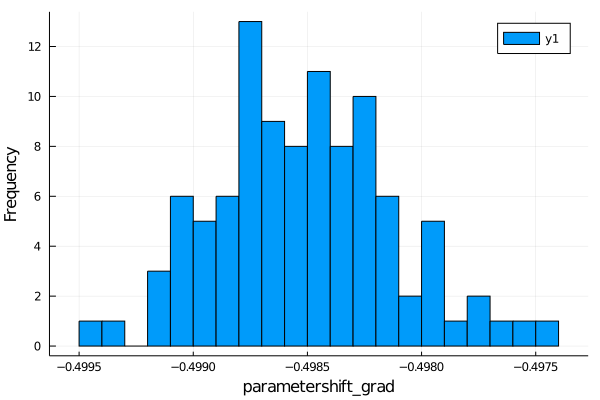

In [7]:
using Plots 

p = []

for _ in 1:100
    push!(p, first(parametershift_grad()))
end

histogram(p, bins=20, xlabel="parametershift_grad", ylabel="Frequency")